# Comparison between Nestorov and normal momentum approaches 

## Import libreries and define global variables

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from NeuralNetwork import NeuralNetwork
from utils import get_data, onehot_encoding, grid_search, save_dict_to_file, load_dict_from_file
from Layer import Layer, Input
from functions import accuracy, MSE, MEE
import pandas as pd

In [11]:
DIR = '/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/' # Directory of the package.

## Import datasets

### Import MONK datasets

In [12]:
df = get_data(f'{DIR}data/MONK/monks-1.train')
df_test = get_data(f'{DIR}data/MONK/monks-1.test')

X_train_monk, y_train_monk = df.drop(columns=['target','id']).to_numpy().T, df['target'].apply(lambda x: int(x)).to_numpy().T
X_test_monk, y_test_monk = df_test.drop(columns=['target','id']).to_numpy().T, df_test['target'].apply(lambda x: int(x)).to_numpy().T

### Import CUP dataset

Define the fraction of dataset which will represent the internal test set.

In [13]:
test_frac = 1/4

In [14]:
names = ['id', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 
         'feature_7', 'feature_8', 'feature_9', 'feature_10', 'target_x', 'target_y','target_z']

df = pd.read_csv(f"{DIR}data/ML-CUP23-TR.csv", names=names, comment='#')

targets = ['target_x', 'target_y', 'target_z']
features = list(set(names) - {'id', 'target_x', 'target_y', 'target_z'})

df = df.sample(frac=1)

train_test_div = round((1-test_frac) * df.shape[0])

X_train_cup, y_train_cup = df[:train_test_div][features].to_numpy().T, df[:train_test_div][targets].to_numpy().T
X_test_cup, y_test_cup = df[train_test_div:][features].to_numpy().T, df[train_test_div:][targets].to_numpy().T

## Data preprocessing

### MONK preprocessing

Process one hot encoding on training and test sets.

In [15]:
X_train_monk = onehot_encoding(X_train_monk)
X_test_monk = onehot_encoding(X_test_monk)

### CUP preprocessing

Decide which data preprocessing method apply to cup training set:
+ MinMax normalization (preprocessing = 1)
+ Standardization (preprocessing = 2)

In [16]:
def standardize(input_array):
    """
    Standardize each feature in an input array using Z-score standardization.

    Parameters:
    - input_array (numpy.ndarray): Input array with dimensions (features, samples).

    Returns:
    - numpy.ndarray: Standardized input array.
    """
    mean_vals = np.mean(input_array, axis=1, keepdims=True)
    std_dev_vals = np.std(input_array, axis=1, keepdims=True)

    # Ensure no division by zero
    std_dev_vals[std_dev_vals == 0] += 1e-6

    standardized_array = (input_array - mean_vals) / std_dev_vals

    return standardized_array


In [17]:
def minmax_norm(input_array):
    X_train_norm = []
    for elem in input_array:
        X_train_norm.append((elem - np.min(elem)) / (np.max(elem) - np.min(elem)))
    return np.array(X_train_norm)

In [18]:

X_train_norm = minmax_norm(X_train_cup)
X_test_norm = minmax_norm(X_test_cup)

X_train_stand = standardize(X_train_cup)
X_test_stand = standardize(X_test_cup)

## CUP

Define training and model hyperparameters

In [19]:
orig_params = {'hidden_dim': 50,
        'hidden_act_func': 'tanh',
        'hidden_dim2': 50,
        'hidden_act_func2' : 'tanh',
        'eta': 0.001,
        'lam': 0.000,
        'alpha': 0.9,
        'n_batch': 150,
        'use_opt':0,
        'nest': True,
        'l1_reg' : False,
        'epochs' : 500,
        'loss' : 'MSE',
        'output_act_func': 'lin'
        }
seed = np.random.randint(10,1000)

### No normalization

Build model

In [20]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

init_weights_list = model.get_initial_weights_list()

Training:

In [21]:
np.random.seed(seed)
history_nonorm = model.train(X_train_cup, y_train_cup,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 6.136e+02, val_loss: 5.973e+02; train_MEE: 3.754e+01, val_MEE: 3.649e+01  lr : 0.001


Epoch 1: train_loss: 3.378e+02, val_loss: 3.268e+02; train_MEE: 2.685e+01, val_MEE: 2.619e+01  lr : 0.001
Epoch 2: train_loss: 1.399e+02, val_loss: 1.349e+02; train_MEE: 1.737e+01, val_MEE: 1.707e+01  lr : 0.001
Epoch 3: train_loss: 5.923e+01, val_loss: 5.955e+01; train_MEE: 1.160e+01, val_MEE: 1.170e+01  lr : 0.001
Epoch 4: train_loss: 3.954e+01, val_loss: 4.271e+01; train_MEE: 9.867e+00, val_MEE: 1.017e+01  lr : 0.001
Epoch 5: train_loss: 2.684e+01, val_loss: 2.996e+01; train_MEE: 8.159e+00, val_MEE: 8.484e+00  lr : 0.001
Epoch 6: train_loss: 1.923e+01, val_loss: 2.190e+01; train_MEE: 6.701e+00, val_MEE: 6.975e+00  lr : 0.001
Epoch 7: train_loss: 1.416e+01, val_loss: 1.699e+01; train_MEE: 5.696e+00, val_MEE: 6.007e+00  lr : 0.001
Epoch 8: train_loss: 1.147e+01, val_loss: 1.360e+01; train_MEE: 5.049e+00, val_MEE: 5.283e+00  lr : 0.001
Epoch 9: train_loss: 9.449e+00, val_loss: 1.128e+01; train_MEE: 4.524e+00, val_MEE: 4.766e+00  lr : 0.001
Epoch 10: train_loss: 8.035e+00, val_loss: 9.9

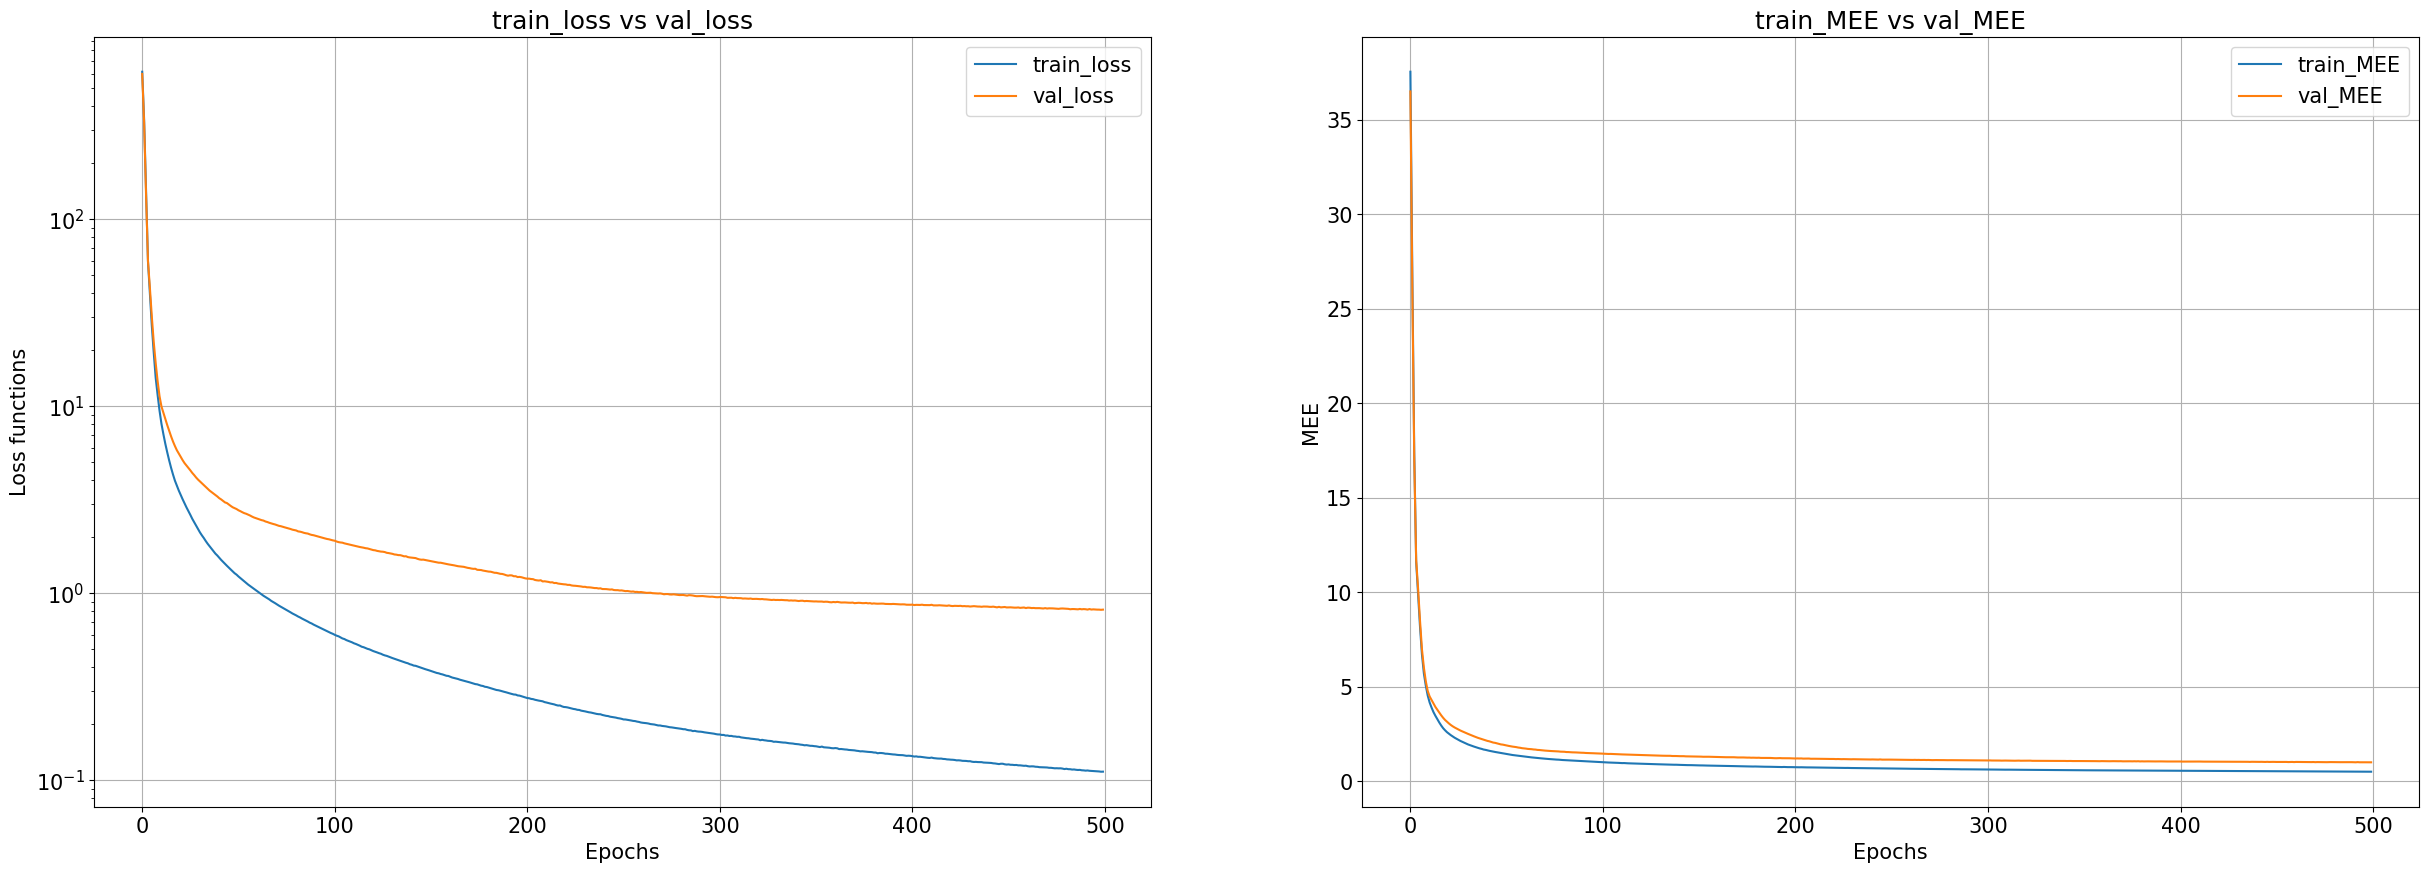

In [22]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_nonorm['train_loss'],label='train_loss')
plt.plot(history_nonorm['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_nonorm['train_MEE'],label='train_MEE')
plt.plot(history_nonorm['val_MEE'], label='val_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

### minmax normalization


Build model


In [23]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

model.set_initial_weights(init_weights_list)

Training:


In [24]:
np.random.seed(seed)
history_norm = model.train(X_train_norm, y_train_cup,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 6.141e+02, val_loss: 5.966e+02; train_MEE: 3.846e+01, val_MEE: 3.754e+01  lr : 0.001
Epoch 1: train_loss: 3.965e+02, val_loss: 3.859e+02; train_MEE: 3.159e+01, val_MEE: 3.115e+01  lr : 0.001
Epoch 2: train_loss: 2.009e+02, val_loss: 1.906e+02; train_MEE: 2.175e+01, val_MEE: 2.106e+01  lr : 0.001
Epoch 3: train_loss: 9.286e+01, val_loss: 8.622e+01; train_MEE: 1.441e+01, val_MEE: 1.388e+01  lr : 0.001
Epoch 4: train_loss: 5.076e+01, val_loss: 4.928e+01; train_MEE: 1.082e+01, val_MEE: 1.076e+01  lr : 0.001
Epoch 5: train_loss: 3.411e+01, val_loss: 3.655e+01; train_MEE: 9.153e+00, val_MEE: 9.424e+00  lr : 0.001
Epoch 6: train_loss: 2.282e+01, val_loss: 2.547e+01; train_MEE: 7.468e+00, val_MEE: 7.772e+00  lr : 0.001
Epoch 7: train_loss: 1.547e+01, val_loss: 1.878e+01; train_MEE: 6.069e+00, val_MEE: 6.558e+00  lr : 0.001
Epoch 8: train_loss: 1.127e+01, val_loss: 1.437e+01; train_MEE: 5.034e+00, val_MEE: 5.631e+00  lr : 0.001
Epoch 9: train_loss: 8.878e+00, val_loss: 1.13

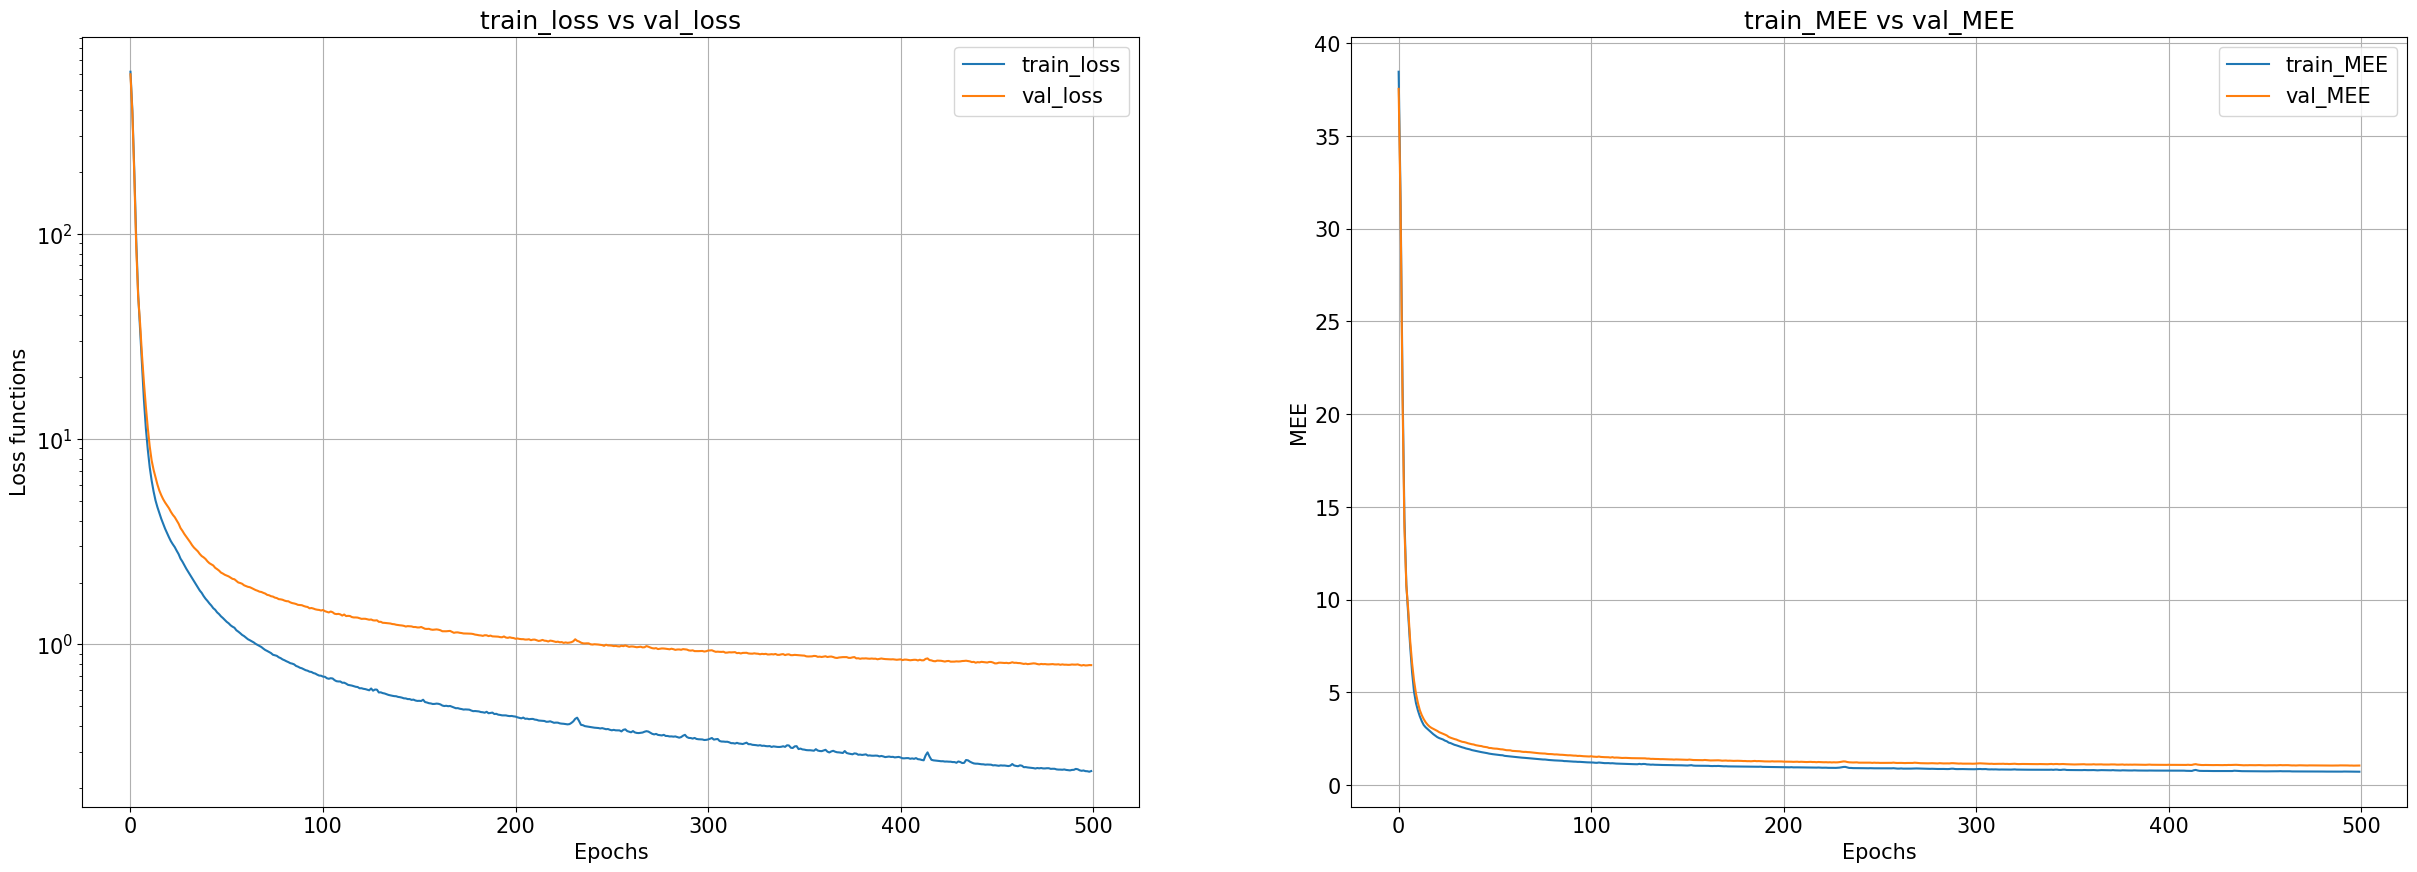

In [25]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_norm['train_loss'],label='train_loss')
plt.plot(history_norm['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_norm['train_MEE'],label='train_MEE')
plt.plot(history_norm['val_MEE'], label='val_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### standardization


Build model


In [26]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

model.set_initial_weights(init_weights_list)

Training:


In [27]:
np.random.seed(seed)
history_stand = model.train(X_train_stand, y_train_cup,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 6.167e+02, val_loss: 6.006e+02; train_MEE: 3.779e+01, val_MEE: 3.670e+01  lr : 0.001
Epoch 1: train_loss: 3.533e+02, val_loss: 3.422e+02; train_MEE: 2.774e+01, val_MEE: 2.705e+01  lr : 0.001
Epoch 2: train_loss: 1.532e+02, val_loss: 1.504e+02; train_MEE: 1.835e+01, val_MEE: 1.817e+01  lr : 0.001
Epoch 3: train_loss: 5.838e+01, val_loss: 5.968e+01; train_MEE: 1.156e+01, val_MEE: 1.166e+01  lr : 0.001
Epoch 4: train_loss: 2.938e+01, val_loss: 3.032e+01; train_MEE: 8.438e+00, val_MEE: 8.384e+00  lr : 0.001
Epoch 5: train_loss: 1.814e+01, val_loss: 1.982e+01; train_MEE: 6.526e+00, val_MEE: 6.564e+00  lr : 0.001
Epoch 6: train_loss: 1.468e+01, val_loss: 1.774e+01; train_MEE: 5.814e+00, val_MEE: 6.236e+00  lr : 0.001
Epoch 7: train_loss: 1.248e+01, val_loss: 1.544e+01; train_MEE: 5.328e+00, val_MEE: 5.769e+00  lr : 0.001
Epoch 8: train_loss: 1.040e+01, val_loss: 1.317e+01; train_MEE: 4.831e+00, val_MEE: 5.269e+00  lr : 0.001
Epoch 9: train_loss: 8.713e+00, val_loss: 1.15

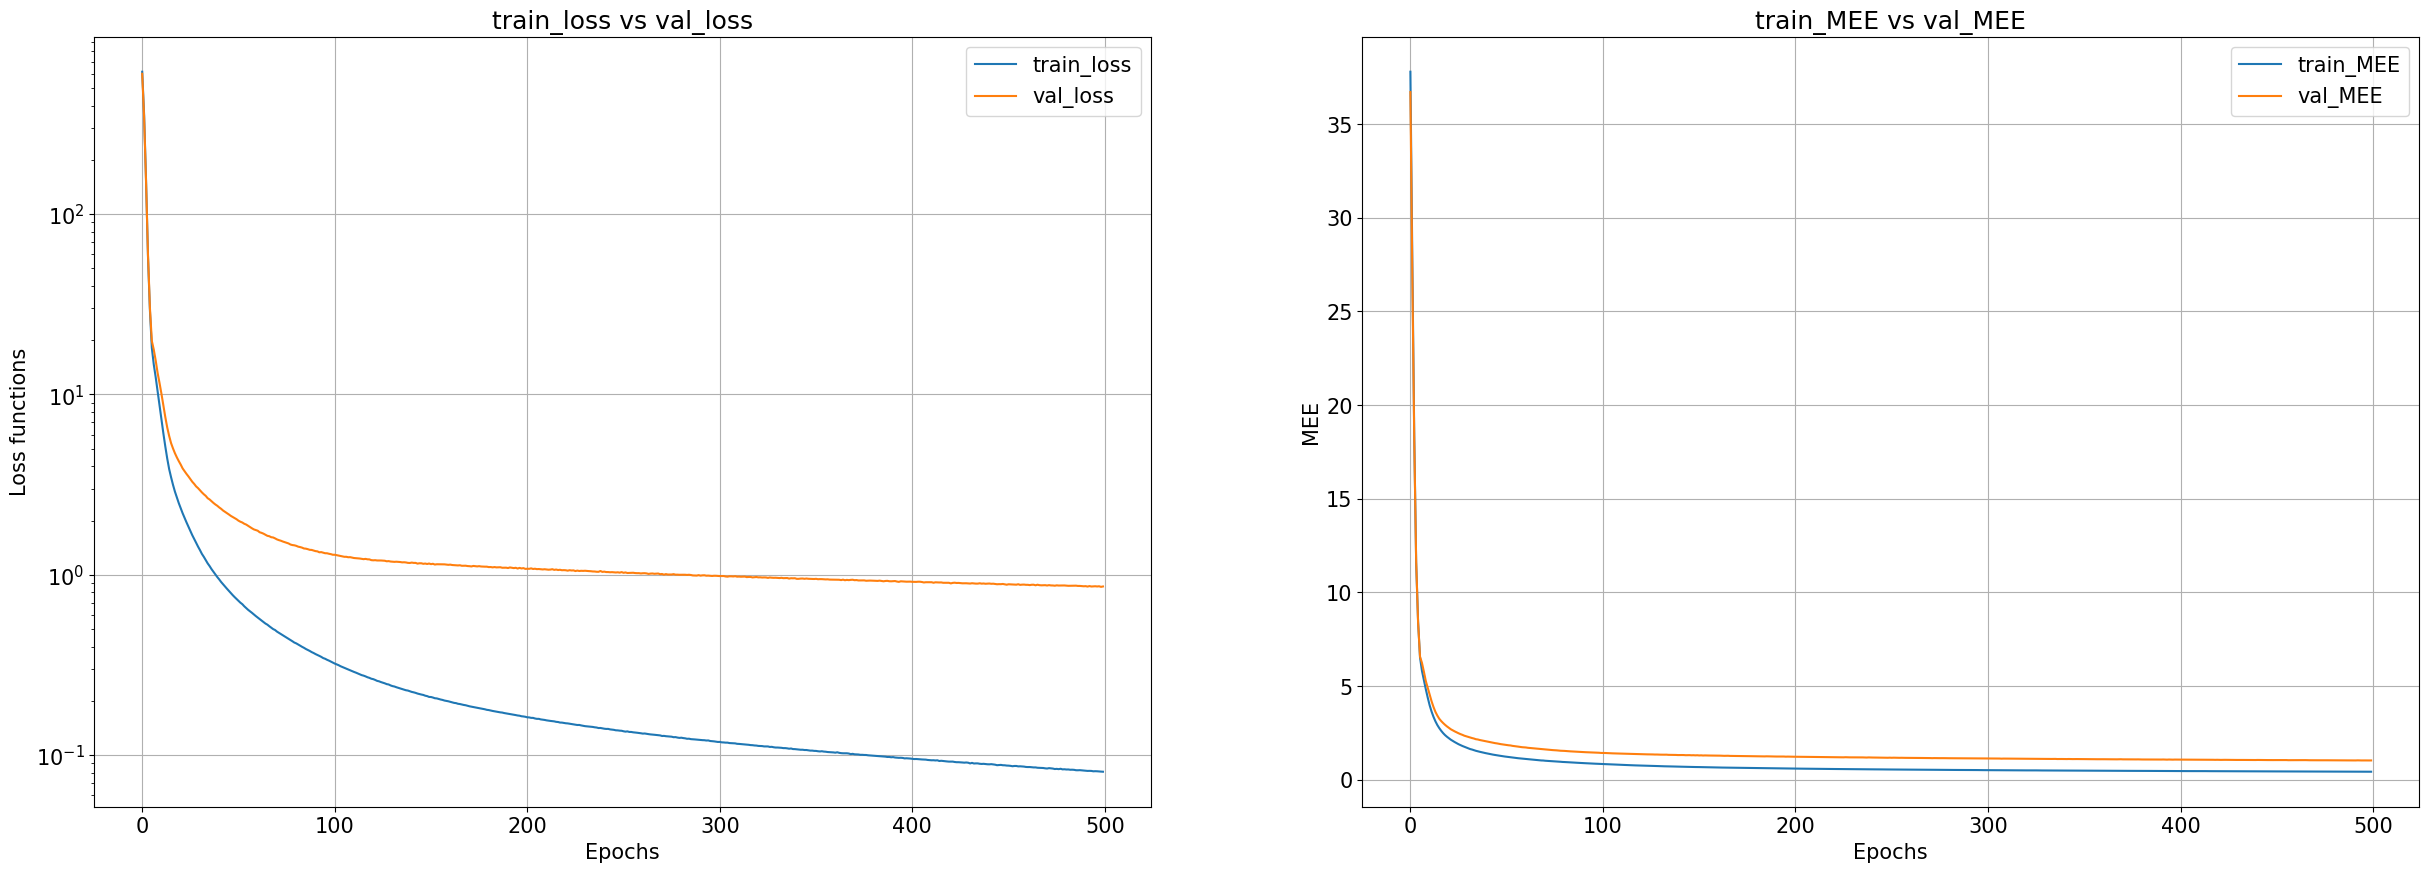

In [28]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_stand['train_loss'],label='train_loss')
plt.plot(history_stand['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_stand['train_MEE'],label='train_MEE')
plt.plot(history_stand['val_MEE'], label='val_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### Comparison

In [29]:
plt.figure(1,figsize=(15,8))
#plt.subplot(1,2,1)
plt.plot(history_nonest['train_loss'], '-', label='train_loss_nonest', color='blue')
plt.plot(history_nonest['val_loss'], '-', label='val_loss_nonest', color='orange')
plt.plot(history_nest['train_loss'], '--', label='train_loss_nest', color='blue')
plt.plot(history_nest['val_loss'], '--', label='val_loss_nest', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.figure(2,figsize=(15,8))
#plt.subplot(1,2,2)
plt.plot(history_nonest['train_MEE'], '-',label='train_MEE_nonest', color='blue')
plt.plot(history_nonest['val_MEE'], '-', label='val_MEE_nonest', color='orange')
plt.plot(history_nest['train_MEE'], '--', label='train_MEE_nest', color='blue')
plt.plot(history_nest['val_MEE'], '--', label='val_MEE_nest', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

NameError: name 'history_nonest' is not defined

<Figure size 1500x800 with 0 Axes>